In [49]:
#!pip install backtrader
#!pip install yfinance
#!pip install --upgrade pandas yfinance
!pip install python-dateutil


In [50]:
#import backtrader as bt
#import pandas as pd
#import datetime  # For datetime objects
#import os.path  # To manage paths
#import sys 
#from __future__ import (absolute_import, division, print_function,
#                        unicode_literals)
#import yfinance as yf
from dateutil.relativedelta import relativedelta


In [76]:
class CustomCSVData(bt.feeds.GenericCSVData):
    # Définir les lignes (colonnes) du fichier CSV
    lines = ('prob0', 'prob1', 'prob2', 'prob3')

    # Ajouter les paramètres pour le nom de la colonne et le format
    params = (
        ('dtformat', '%Y-%m-%d'),
        ('datetime', 0),
        ('prob0', 1),
        ('prob1', 2),
        ('prob2', 3),
        ('prob3', 4),
        ('time', -1),
        ('open', -1),
        ('high', -1),
        ('low', -1),
        ('close', -1),
        ('volume', -1),
        ('openinterest', -1),
    )


Dans cet exemple, CustomCSVData est configuré pour charger un fichier CSV avec les colonnes de date et de probabilités. Les colonnes time, open, high, low, close, volume, et openinterest sont définies avec l'index -1 car elles ne sont pas présentes dans votre fichier. Vous pouvez accéder à ces données dans votre stratégie en utilisant self.datas[0].prob0, self.datas[0].prob1, etc.


In [67]:
class TestStrategy(bt.Strategy):
    


    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
        
        

    def __init__(self):
        self.dataclose1 = self.datas[0].close
        self.dataclose2 = self.datas[1].close
        self.order = None
        self.buy_executed = False
        self.sell_day = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

                self.bar_executed= len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def next(self):
        # Si nous n'avons pas encore acheté, faisons l'achat initial
        if not self.buy_executed:
            total_value = self.broker.getvalue()
            size1 = total_value * 0.07 / self.dataclose1[0]
            size2 = total_value * 0.03 / self.dataclose2[0]
            self.buy(data=self.datas[0], size=size1)
            self.buy(data=self.datas[1], size=size2)
            self.sell_day = len(self) + 5  # Définir le jour de vente
            self.buy_executed = True

        # Vendre après 5 jours
        if self.buy_executed and len(self) == self.sell_day:
            self.close(data=self.datas[0])
            self.close(data=self.datas[1])

                

In [79]:
if __name__ == '__main__':
    cerebro = bt.Cerebro()
    
    
    cerebro.addstrategy(TestStrategy)
    
    # Create a Data Feed
    data1 = bt.feeds.YahooFinanceCSVData(
        dataname='Bloomberg_Barclays_US_Government_Inflation-Linked_7_to_10_Years.csv',
        # Do not pass values before this date
        fromdate=datetime.datetime(2000, 1, 1),
        # Do not pass values after this date
        todate=datetime.datetime(2023, 12, 31),
        reverse=False)
    
    data2=bt.feeds.YahooFinanceCSVData(
        dataname='snpValues.csv',
        # Do not pass values before this date
        fromdate=datetime.datetime(2017, 1, 10),
        # Do not pass values after this date
        todate=datetime.datetime(2023, 12, 31),
        reverse=False)
    
    GMM = CustomCSVData(
        dataname='GMM_Proba.csv',
        fromdate=datetime.datetime(2017, 1, 10),
        todate=datetime.datetime(2023, 12, 31),
        nullvalue=0.0,
)
    HMM = CustomCSVData(
        dataname='HMM_Proba.csv',
        fromdate=datetime.datetime(2017, 1, 10),
        todate=datetime.datetime(2023, 12, 31),
        nullvalue=0.0,
)
    
    # Add the Data Feed to Cerebro
    cerebro.adddata(data1)
    cerebro.adddata(data2)
    cerebro.adddata(GMM)
    cerebro.adddata(HMM)

   
    cerebro.broker.setcash(100000.0)
    cerebro.broker.setcommission(commission=0.001)

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    cerebro.run()

    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    

Starting Portfolio Value: 100000.00
2017-01-06, BUY EXECUTED, Price: 2268.60, Cost: 2999.60, Comm 3.00
2017-01-13, BUY EXECUTED, Price: 296.87, Cost: 7035.07, Comm 7.04
2017-01-13, SELL EXECUTED, Price: 2271.90, Cost: 2999.60, Comm 3.00
2017-01-20, SELL EXECUTED, Price: 296.28, Cost: 7035.07, Comm 7.02
Final Portfolio Value: 99970.32


<IPython.core.display.Javascript object>


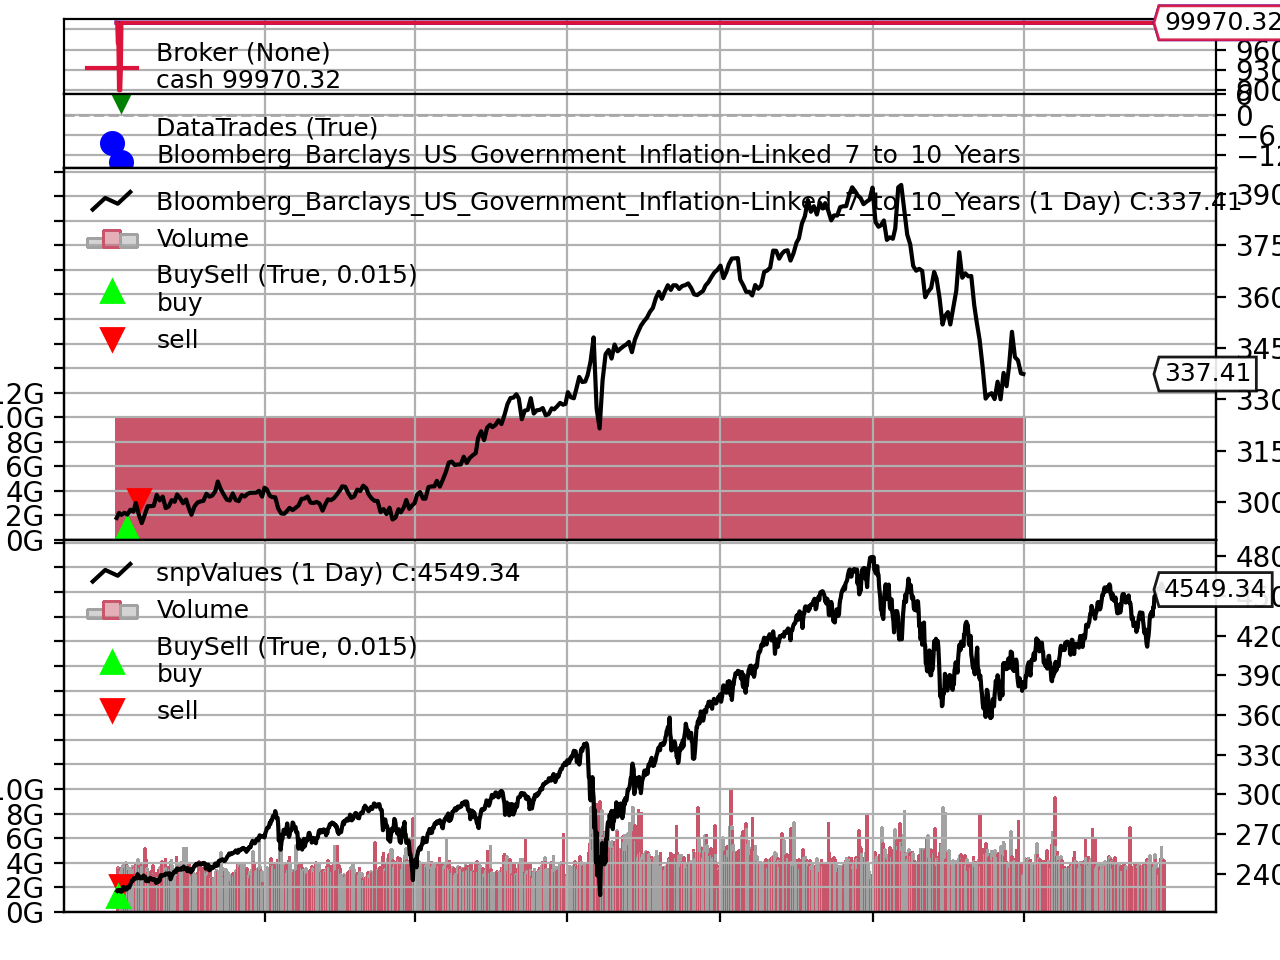

[[<Figure size 640x480 with 6 Axes>]]

In [60]:
cerebro.plot()

In [23]:
data1()